In [1]:
import clmm
from clmm import Cosmology
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

import sys  #
import h5py #
import matplotlib.pyplot as plt  #
import numpy as np  #T
import random  #
import pandas  #
from scipy import integrate, signal   #T
from scipy.stats import binned_statistic  #T
from scipy.stats import norm   #T
from scipy.special import erf   #T
import astropy   
import astropy.constants as const
import astropy.units as units
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FlatwCDM
from IPython.display import clear_output
import os
import corner
import emcee
from multiprocessing import Pool
from matplotlib.pyplot import cm
import time as pytime

#cosmo = Cosmology(H0=71.0, Omega_dm0=0.2248, Omega_b0=0.2648 - 0.2248, Omega_k0=0.0)
cosmo = Cosmology(H0=70.0, Omega_dm0=0.2248, Omega_b0=0.3 - 0.2248, Omega_k0=0.0)
cosmo_astropy = FlatwCDM(H0=71, Om0=0.2648, Ob0=0.04479, w0=-1.000000)

In [84]:
from clmm.dataops import _calculate_major_axis, _rotate_shear

In [85]:
print(cosmo.be_cosmo["h"])

0.7


In [2]:
def measure_Delta_Sigma_const_triaxiality(w, gamma1, Sigma_crit) :
    """Measure Delta sigma const quadrupole value for individual galaxies.

    Parameters
    ----------
    w: float or array
        Weight computed for each galaxy by the descrition as given in Shin et al. (https://doi.org/10.1093/mnras/stx3366)
    gamma1: float or array
        Shear component gamma 1
    Sigma_crit: float
        Critical surface mass density in M_{sun}/Mpc^{2}

    Returns
    -------
    dsconst_data: The measured "4theta" quadrupole component from the input shear measurements for each galaxy
    """
    dsconst_data = w * Sigma_crit * gamma1 / w
    return dsconst_data

def measure_Delta_Sigma_4theta_triaxiality(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
    """Measure Delta sigma 4theta quadrupole value for individual galaxies.

    Parameters
    ----------
    w1: float or array
        Weight computed for each galaxy by the descrition as given in Shin et al. (https://doi.org/10.1093/mnras/stx3366)
    w2: float or array
        Weight computed for each galaxy by the descrition as given in Shin et al. (https://doi.org/10.1093/mnras/stx3366)
    gamma1: float or array
        Shear component gamma 1
    gamma2: float or array
        Shear component gamma 2
    theta: float or array
        Position Angle of galaxy measured counter-clockwise from the gamma1 direction
    Sigma_crit: float
        Critical surface mass density in M_{sun}/Mpc^{2}

    Returns
    -------
    ds4theta_data: The measured "const" quadrupole component from the input shear measurements for each galaxy
    """
    ds4theta_data = Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)
    return ds4theta_data

def measure_weights_triaxiality(Sigma_crit, theta, Sigma_shape=0.0001, Sigma_meas=0) :
    """Measure weight values for quadrupole measurement of individual galaxies. 
    Using Equations 35, 32, 33 from Shin et al. 2018 (https://doi.org/10.1093/mnras/stx3366)

    Parameters
    ----------
    Sigma_crit: float
        Critical surface mass density in M_{sun}/Mpc^{2}
    theta: float or array
        Position Angle of galaxy measured counter-clockwise from the gamma1 direction
    Sigma_shape: Float, optional
        Scatter in the shape measurement from shape noise
    Sigma_meas: Float, optional
        Measurement error for shapes

    Returns
    -------
    w, w1, w2: float or array
        Weights for each galaxy
    """
	
    w  = 1 / (Sigma_crit**2 * (Sigma_shape**2 + Sigma_meas**2))
    w1 = np.cos(4*theta)**2 * w
    w2 = np.sin(4*theta)**2 * w
    return w, w1, w2

def make_binned_estimators_triaxiality(gamma1, gamma2, x_arcsec, y_arcsec, z_cluster, z_source, cosmo, monopole_bins=15,
                                      quadrupole_bins=15, r_min=0.3, r_max=2.5):
    """
    Makes radially binned profiles for Monopole, Quadrupole (4theta and const) as described in Shin et al. 2018
    Parameters
    ----------
    gamma1: float or array
        Shear component gamma 1
    gamma2: float or array
        Shear component gamma 2
    x_arcsec: float or array
        X position in arcsec when cluster center is at 0.0 and x axis is assumed to be along the major axis of the cluster
    y_arcsec: float or array
        Y position in arcsec when cluster center is at 0.0
    z_cluster: float
        Redshift of lens cluster
    cosmo: clmm.cosmology.Cosmology object
        CLMM Cosmology object 
    monopole_bins: float, optional
        Number of bins for monopole lensing profile
    quadrupole_bins: float, optional
        Number of bins for quadrupole lensing profiles (4theta, const)
    r_min: Float, optional
        Minimum radial distance to measure monopole and quadrupole shear profiles in Mpc (Default is 0.3 Mpc)
    r_max: Float, optional
        Maximum radial distance to measure monopole and quadrupole shear profiles in Mpc (Default is 2.5 Mpc)

    Returns
    -------
    ds_mono: float or array
        Binned monopole lensing profile
    ds_mono_err: float or array
        Uncertainty for the binned monopole lensing shear profile
    r_mono: float or array
        Bin centers for the monopole lensing shear profile
    ds_4theta: float or array
        Binned binned quadrupole 4-theta lensing shear profile
    ds_4theta_err: float or array
        Uncertainty for the binned quadrupole 4-theta lensing shear profile
    ds_const: float or array
        Binned binned quadrupole const lensing shear profile
    ds_const_err: float or array
        Uncertainty for the binned quadrupole const lensing shear profile
    r_quad: float or array
        Bin centers for the quadrupole lensing shear profiles (4theta and const)
    """
    
    sigma_crit = cosmo.eval_sigma_crit(z_cluster,z_source)
    r = np.sqrt((x_arcsec**2 + y_arcsec**2)) #In arcsecs
    theta = np.arctan2(y_arcsec, x_arcsec)
    r_mpc = r*cosmo.eval_da(z_cluster) * np.pi/180.0 * 1/3600 #In Mpc
    
    w, w1, w2 = measure_weights_triaxiality(sigma_crit, theta)
    DS4theta = measure_Delta_Sigma_4theta_triaxiality(w1, w2, gamma1, gamma2, theta, sigma_crit)
    DSconst = measure_Delta_Sigma_const_triaxiality(w, gamma1, sigma_crit)
    
    #Binning for Quadrupole measurements DS4theta and DSconst
    bins=quadrupole_bins
    r_min = r_min
    r_max = r_max
    
    bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins)
    N_i = []
    for i in np.arange(bins-1):
        N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
    N_i=np.array(N_i)


    result = binned_statistic(r_mpc, gamma1, statistic='mean', bins=bin_edges)
    gamma1_i = result.statistic
    res = binned_statistic(r_mpc, gamma2, statistic='mean', bins=bin_edges)
    gamma2_i = res.statistic
    res = binned_statistic(r_mpc, DS4theta, statistic='mean', bins=bin_edges)
    DS4theta_i_err = binned_statistic(r_mpc, DS4theta, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
    DS4theta_i = res.statistic
    res = binned_statistic(r_mpc, DSconst, statistic='mean', bins=bin_edges)
    DSconst_i = res.statistic
    DSconst_i_err = binned_statistic(r_mpc, DSconst, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
    r_i = bin_edges
    
    #Binning for Monopole Measurements:
    bins_mono=monopole_bins
    bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins_mono)
    N_i = []
    for i in np.arange(bins_mono-1):
        N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
    N_i=np.array(N_i)

    r_mono = bin_edges
    res = binned_statistic(r_mpc, -gamma1*np.cos(2*theta)-gamma2*np.sin(2*theta), statistic='mean', bins=bin_edges)
    gammat_mono = res.statistic
    ds_mono_err = binned_statistic(r_mpc, -gamma1*np.cos(2*theta)-gamma2*np.sin(2*theta), statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)*sigma_crit
    ds_mono = gammat_mono*sigma_crit
        
    # SAFEGUARD AGAINST BINS WITH NANs and 0.0s
    
    ind = np.invert(np.isnan(ds_mono) | np.isnan(ds_mono_err))
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind]
    r_mono = np.sqrt(r_mono[:-1]*r_mono[1:])[ind]
    ind = (ds_mono!= 0.0) & (ds_mono_err!= 0.0)
    ds_mono = ds_mono[ind]
    ds_mono_err = np.abs(ds_mono_err[ind]) 
    r_mono = r_mono[ind] 
    
    ind = np.invert(np.isnan(DS4theta_i) | np.isnan(DS4theta_i_err) | np.isnan(DSconst_i) | np.isnan(DSconst_i_err))
    ds_4theta = DS4theta_i[ind]
    ds_4theta_err = np.abs(DS4theta_i_err[ind])
    ds_const = DSconst_i[ind] 
    ds_const_err = np.abs(DSconst_i_err[ind])
    r_quad = np.sqrt(r_i[:-1]*r_i[1:])[ind]
    
    return ds_mono,ds_mono_err,r_mono,ds_4theta,ds_4theta_err,ds_const,ds_const_err,r_quad

''' DEPRECATED CODE:
elif method == 2 :
        ## METHOD 2 ## -- DEPRECATED AS WE WANT DIFFERENT NUMBER OF BINS FOR MONOPOLE AND QUADRUPOLE

        Nbins = bins-1
        arcsec_to_Mpc = 0.00588784182755241
        r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)

        ds_mono=[]
        ds_mono_err=[]
        delta_sigmas_4theta = []
        delta_sigmas_const = []
        delta_sigmas_4theta_cross = []
        delta_sigmas_const_cross = []
        delta_sigmas_4theta_err = []
        delta_sigmas_const_err = []
        delta_sigmas_4theta_cross_err = []
        delta_sigmas_const_cross_err = []
        for i in range(Nbins):
            select = (r_inds == i)
            theta_i = theta[select]
            gamma1_i = gamma1[select]
            gamma2_i = gamma2[select]
            w_i, w1_i, w2_i = weights(sigma_c, theta_i)
            DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_c)
            DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_c)
            DSmonoi = gamma1_i*np.cos(2*theta_i)*sigma_c

            ds_mono.append(-2*np.mean(DSmonoi))
            ds_mono_err.append(2*np.std(DSmonoi)/np.sqrt(len(DSmonoi)))
            delta_sigmas_4theta.append(np.mean(DS4thetai))
            delta_sigmas_4theta_err.append(np.std(DS4thetai)/np.sqrt(len(DS4thetai)))
            delta_sigmas_const.append(np.mean(DSconsti))
            delta_sigmas_const_err.append(np.std(DSconsti)/np.sqrt(len(DSconsti)))
            #delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
            #delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

        r_i=np.array(rbin_edges + (rbin_edges[1]-rbin_edges[0]))
        r_mono=r_i
        ds_mono = np.array(ds_mono)
        ds_mono_err = np.array(ds_mono_err)
        DS4theta_i = np.array(delta_sigmas_4theta)
        DS4theta_i_err = np.array(delta_sigmas_4theta_err)
        DSconst_i = np.array(delta_sigmas_const)
        DSconst_i_err = np.array(delta_sigmas_const_err)
'''

' DEPRECATED CODE:\nelif method == 2 :\n        ## METHOD 2 ## -- DEPRECATED AS WE WANT DIFFERENT NUMBER OF BINS FOR MONOPOLE AND QUADRUPOLE\n\n        Nbins = bins-1\n        arcsec_to_Mpc = 0.00588784182755241\n        r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)\n\n        ds_mono=[]\n        ds_mono_err=[]\n        delta_sigmas_4theta = []\n        delta_sigmas_const = []\n        delta_sigmas_4theta_cross = []\n        delta_sigmas_const_cross = []\n        delta_sigmas_4theta_err = []\n        delta_sigmas_const_err = []\n        delta_sigmas_4theta_cross_err = []\n        delta_sigmas_const_cross_err = []\n        for i in range(Nbins):\n            select = (r_inds == i)\n            theta_i = theta[select]\n            gamma1_i = gamma1[select]\n            gamma2_i = gamma2[select]\n            w_i, w1_i, w2_i = weights(sigma_c, theta_i)\n            DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta

In [7]:
## With emcee:
import clmm
def log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params):
    
    #sigma_c = 3.77988e+15
    #z_cl=0.47
    #z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_mono
    
    #model:
    #ds_model = clmm.compute_delta_sigma_excess_triaxiality(ell=ell, r_proj=r_mono, mdelta=mdelta, cdelta=cdelta, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
    #                                         sample_N=10000, delta_mdef=200, massdef='critical')#/sigma_c
    ds_model = clmm.compute_excess_surface_density_triaxial(r_proj=r_mono, mdelta=mdelta, cdelta=cdelta, ell=ell, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw',
                                                            n_grid=10000, delta_mdef=200, massdef='critical', term='mono')

    # Gaussian likelihood:
    #sigma = np.full(len(r_mono), ds_model*0.01) 
    sigma = ds_mono_err
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
    chi2 = ((ds_data - ds_model)**2 / (sigma)**2)
    term2 = -0.5*np.sum(chi2)


    return term1+term2

def log_likelihood_quadrupole_4theta(ds_quad_4theta,ds_quad_4theta_err, r_quad,params):
    #sigma_c = 3.77988e+15
    #z_cl=0.47
    #z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_quad_4theta
    
    #model:
    #ds_model = clmm.compute_delta_sigma_4theta_triaxiality(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, halo_profile_model='nfw', 
    #                                         sample_N=10000, delta_mdef=200, massdef='critical')#/sigma_c
    ds_model = clmm.compute_excess_surface_density_triaxial(r_proj=r_quad, mdelta=mdelta, cdelta=cdelta, ell=ell, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw',
                                                            n_grid=10000, delta_mdef=200, massdef='critical', term='quad_4theta')
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_4theta_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params):
    #sigma_c = 3.77988e+15
    #z_cl=0.47
    #z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_quad_const
    
    #model:
    #ds_model = clmm.compute_delta_sigma_const_triaxiality(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, halo_profile_model='nfw', 
    #                                         sample_N=10000, delta_mdef=200, massdef='critical')#/sigma_c
    ds_model = clmm.compute_excess_surface_density_triaxial(r_proj=r_quad, mdelta=mdelta, cdelta=cdelta, ell=ell, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw',
                                                            n_grid=10000, delta_mdef=200, massdef='critical', term='quad_const')
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_const_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def priors(params, limits):
    
    a,b,c = params
    if (a < limits[0][0] or a > limits[0][1]):        #mdelta
        return -np.inf
    elif (b < limits[1][0] or b > limits[1][1]):      #cdelta
        return -np.inf
    elif (c < limits[2][0] or c > limits[2][1]):      #ell
        return -np.inf
    #elif (d < limits[3][0] or d > limits[3][1]):      #theta_e
    #    return -np.inf

    else:
        return 0.0
    

def log_posterior(params):
    
    mdelta,cdelta,ell = params    
    
    #rotation:
    #gamma1_tilde,gamma2_tilde,x_arcsec_tilde,y_arcsec_tilde = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)
    #ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_binned_estimators_triaxiality(gamma1_tilde, gamma2_tilde, x_arcsec_tilde, y_arcsec_tilde, z_cluster=0.47, z_source=0.8, cosmo=cosmo, r_min=0.3)

    #Evaluate the prior:
    prior=priors(params, limits)
    
    #Avoid likelihood evaluation when prior is -infinity:
    if prior == -np.inf:
        lnP = -np.inf
    else:
        
        lnP = prior + log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) + log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params) + log_likelihood_quadrupole_4theta(ds_quad_4theta, ds_quad_4theta_err, r_quad,params)
        #log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) +
    
    # safeguard against NaNs:
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP
    
#---------------------------------------------DIRECT---------------------------------------------------#

def log_likelihood_direct(gammat, r_mpc, sigma_c,params):
    
    #sigma_c = 3.77988e+15
    #z_cl=0.47
    #z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    gt_data = gammat
    
    
    gt_model = clmm.compute_excess_surface_density(r_mpc, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)/sigma_c
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    gt_sigma=0.001
    sigma = np.full(len(gt_data), gt_sigma)
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((gt_data - gt_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2
    
def log_posterior_direct(params,gamma1, gamma2, x_arcsec, y_arcsec, sigma_c = 3.77988e+15):
    
    mdelta,cdelta,ell = params

    #rotation:
    #theta_e = theta_e*np.pi/180.0 # in radians
    #gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)

    #Evaluate the prior:
    prior=priors(params, limits)

    
    #Avoid likelihood evaluation when prior is -infinity:
    if prior == -np.inf:
        lnP = -np.inf
    else:
        q = np.sqrt((1-ell)/(1+ell))
        theta = np.arctan2(q*y_arcsec, x_arcsec)
        sigma_c = cosmo.eval_sigma_crit(0.47,0.8)
        gammat = -1*gamma1*np.cos(2*theta) - gamma2*np.sin(2*theta)
        r = np.sqrt((x_arcsec)**2*q + (y_arcsec)**2/q)#*np.sqrt(q)
        r_mpc = r*cosmo.eval_da(z_cl) * np.pi/180.0 * 1/3600#0.00588784182755241#
        lnP = prior + log_likelihood_direct(gammat, r_mpc, sigma_c,params)

    # safeguard against NaNs:
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP


In [8]:
def emcee_wrapper(params_key, limits, true_value,
                 ndim, nwalkers, nsteps=1000, nburn=350, filename=None):  
    
    starting_guess_t=[]
    for i in np.arange(len(params_key)):
        guess=[]
        for j in np.arange(nwalkers):
            guess.append((limits[i][1]-limits[i][0])*np.random.random()+limits[i][0])
        starting_guess_t.append(guess)
    starting_guesses=np.column_stack(starting_guess_t)
    print('Starting guesses for ',nwalkers,' chains:')
    print(starting_guesses)
            
    start=pytime.time()
    if filename!=None:
        ## STORING THE CHAINS TO FILE
        backend = emcee.backends.HDFBackend(filename[:-4]+'.h5')
        backend.reset(nwalkers, ndim) ## Comment this line out to append steps to a previous run stored in the file
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=None,
                                             vectorize=False, backend=backend, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
            
    if filename==None:   
        ## RETURNING THE CHAINS WITHOUT STORING TO FILE
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

    end=pytime.time()
    print("Time taken:{0:.1f} seconds".format(end-start))
            
    post = np.concatenate(sampler.chain[:, nburn: , :])
        
    #Corner plot:

    fig = plt.figure(figsize=[10,10])
    figure = corner.corner(post,labels=params_key, quantiles=[0.16, 0.5, 0.84], 
                           show_titles=True, title_fmt='.2e', fig=fig)
    figure.patch.set_facecolor('white')
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    '''
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true_value[xi], color="r")
            ax.axhline(true_value[yi], color="r")
            ax.plot(true_value[xi], true_value[yi], "sr")
            #if yi == 1:
            #    ax.set_xlim([2000,2200])
    '''
    
    if filename!=None:
        plt.savefig(filename[:-4]+"_corner_plot.png",facecolor="white", dpi="figure", format="png")       
    #Chain plot:

    color=iter(cm.rainbow(np.linspace(0,1,nwalkers)))
    # set up a plot with two windows, one for each parameter:
    plt.figure(figsize=(10,5))
    #plt.patch.set_facecolor('white')
    for i in range(len(params_key)):
        plt.subplot(100*len(params_key)+10+i+1)
        plt.ylabel(params_key[i], fontsize=10)
    for j in range(nwalkers):
        c=next(color)
        for i in range(len(params_key)):
            plt.subplot(100*len(params_key)+10+i+1)
            plt.plot(sampler.chain[j,nburn:,i], ',', color=c)
            
    if filename!= None:
        plt.savefig(filename[:-4]+"_chain_plot.png",facecolor="white", dpi="figure", format="png")
    #A_fit = np.quantile((post[:,0].flatten()), 0.5)
    #A_std_fit = np.std(post[:,0].flatten())
    #A.append(A_fit)
    #A_err.append(A_std_fit)
    #print(A)
    #return np.array(A), np.array(A_err), z_final
    mean=[]
    err_minus=[]
    err_plus=[]
    for i in range(len(params_key)):
        mean.append(np.quantile((post[:,i].flatten()), 0.5))
        err_minus.append(np.quantile((post[:,i].flatten()), 0.16))
        err_plus.append(np.quantile((post[:,i].flatten()), 0.84))
    mean = np.array(mean)
    err_plus = np.array(err_plus) - mean
    err_minus = mean - np.array(err_minus)

    return post, mean, err_plus, err_minus

### Tae's DES Y1 Clusters - Y3 shape:

top_mon
top_monx
top_4th
top_con
bottom
DS_mon
DS_monx
DS_4th
DS_con
cov_mon
cov_monx
cov_4th
cov_con
R
Rmid
[ 0.18778632  0.29762126  0.47169791  0.74759081  1.18485159  1.87786321
  2.97621262  4.71697912  7.4759081  11.84851585]
[2.82510823e+14 2.15372201e+14 1.57661198e+14 1.12446961e+14
 7.62647229e+13 5.11145176e+13 2.39825892e+13 1.34407938e+13
 7.65084282e+12 4.95157443e+12]


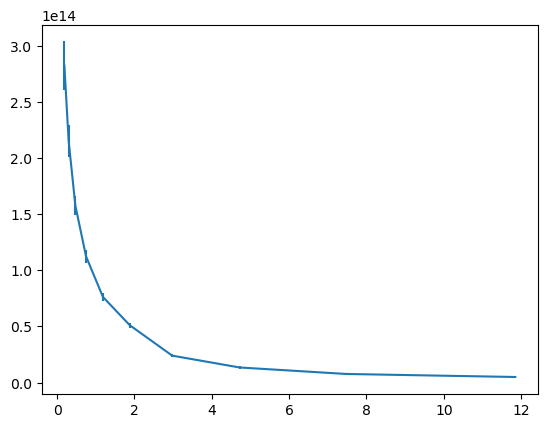

In [9]:
dir_loc_mcmc = "Elliptical_lenses_data/DESY1RM-Y3shape/"
f=dir_loc_mcmc+'DSquad_DESY1RM-Y1shape_R10_0.1-10.0_new.npz'

data=np.load(f)
for k in data.keys():
    print(k)
ds_mono = data['DS_mon']*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_mono_err = np.sqrt(np.diag(data['cov_mon']))*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2

ds_quad_4theta = data['DS_4th']*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_4theta_err = np.sqrt(np.diag(data['cov_4th']))*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_const = data['DS_con']*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_const_err = np.sqrt(np.diag(data['cov_con']))*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2

#r=np.logspace(np.log10(0.1), np.log10(10.0), 11)
#r = (np.sqrt(r[:-1]*r[1:])) #data is in Mpc/h units
#r=r/(cosmo.be_cosmo["h"]) # In Mpc
#print(r)

R = np.logspace(np.log10(0.1),np.log10(10.),11) #[Mpc/h]
R_mid = (2./3.)*(R[1:]**3 - R[:-1]**3)/(R[1:]**2 - R[:-1]**2)
r=R_mid/(cosmo.be_cosmo["h"]) # In Mpc
r_mono = r
r_quad = r
print(r)

'''
r_quad_cut = 0.2
ds_quad_4theta = ds_quad_4theta[r > r_quad_cut]
ds_quad_4theta_err = ds_quad_4theta_err[r > r_quad_cut]
ds_quad_const = ds_quad_const[r > r_quad_cut]
ds_quad_const_err = ds_quad_const_err[r > r_quad_cut]
r_quad = r[r > r_quad_cut]
'''

print(ds_mono)
plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err)
#plt.xscale('log')
#plt.yscale('log')

#MCMC parameters:
params_key=["M200c","c200c","e"]#,r"$\theta_{e}$ in radians"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 5000
nburns = 500
np.random.seed(0)

limits=[[1.0E13,5.0E16],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e
       #[-np.pi/2, 0]]    # theta_e #in degrees

#q_true=0.6 #default = 2/3 for the files in the same directory as this notebook
#ell_true= 1*(1-q_true**2)/(1+q_true**2)
#ell_true= 1*(1-q_true)/(1+q_true)
true_value=[None, None, None]#,None]
z_cl=0.35

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''


# PREP DATA:
#ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_binned_estimators_triaxiality(gamma1, gamma2, x_arcsec, 
#                                                                                                                      y_arcsec, z_cluster=0.47, z_source=0.8, cosmo=cosmo, r_min=0.3)

#If a physical cut is needed in monopole term:
#r_cut = 1.0
#ds_mono = ds_mono[r_mono > r_cut]
#ds_mono_err = ds_mono_err[r_mono > r_cut]
#r_mono = r_mono[r_mono > r_cut]

global run_estimator
global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad

### Tae's DES Y1 Clusters - Y3 shape with McClintock Bins:

top_mon
top_monx
top_4th
top_con
bottom
DS_mon
DS_monx
DS_4th
DS_con
cov_mon
cov_monx
cov_4th
cov_con
R
Rmid
[ 0.17838272  0.26183003  0.38431393  0.56409571  0.82797926  1.21530736
  1.78382725  2.61830033  3.84313931  5.64095706  8.27979264 12.15307357]
[1.38346913e+14 1.08476708e+14 9.38866495e+13 7.88095820e+13
 6.83565601e+13 4.31987976e+13 2.72625179e+13 1.16200739e+13
 6.65037584e+12 4.72066185e+12 4.16939570e+12 2.04985316e+12]


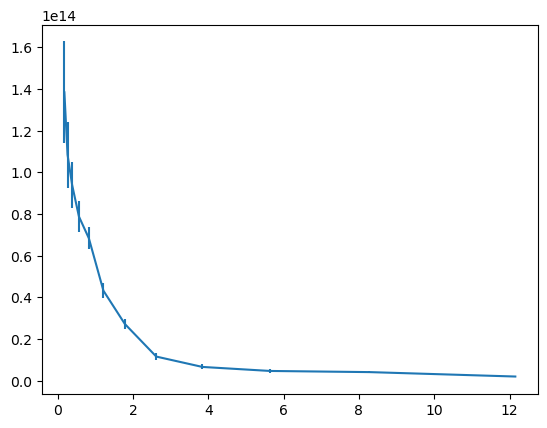

In [82]:
'''
richness bins are ['20.0 - 30.0', '30.0 - 45.0', '45.0 - 60.0', '60.0 - 500.0']
z bins are ['0.2 - 0.35', '0.35 - 0.5', '0.5 - 0.65']
'''
l_low = 20.0
l_hi = 30.0
z_low = 0.2
z_hi = 0.35

dir_loc_mcmc = "Elliptical_lenses_data/DESY1RM-Y3shape-MCCLINTOCK/"
f=dir_loc_mcmc+f'DSquad_DESY1RM_l{l_low}-{l_hi}_z{z_low}-{z_hi}_Y3SHAPE_R12_0.1-10.0.npz'

data=np.load(f)
for k in data.keys():
    print(k)
ds_mono = data['DS_mon']*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_mono_err = np.sqrt(np.diag(data['cov_mon']))*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2

ds_quad_4theta = data['DS_4th']*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_4theta_err = np.sqrt(np.diag(data['cov_4th']))*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_const = data['DS_con']*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_const_err = np.sqrt(np.diag(data['cov_con']))*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2


#r=np.logspace(np.log10(0.1), np.log10(10.0), 11)
#r = (np.sqrt(r[:-1]*r[1:])) #data is in Mpc/h units
#r=r/(cosmo.be_cosmo["h"]) # In Mpc
#print(r)
bins=12
R = np.logspace(np.log10(0.1),np.log10(10.),bins+1) #[Mpc/h]
R_mid = (2./3.)*(R[1:]**3 - R[:-1]**3)/(R[1:]**2 - R[:-1]**2)
r=R_mid/(cosmo.be_cosmo["h"]) # In Mpc
r_mono = r
r_quad = r
print(r)

'''
r_quad_cut = 0.2
ds_quad_4theta = ds_quad_4theta[r > r_quad_cut]
ds_quad_4theta_err = ds_quad_4theta_err[r > r_quad_cut]
ds_quad_const = ds_quad_const[r > r_quad_cut]
ds_quad_const_err = ds_quad_const_err[r > r_quad_cut]
r_quad = r[r > r_quad_cut]
'''

print(ds_mono)
plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err)
#plt.xscale('log')
#plt.yscale('log')

#MCMC parameters:
params_key=["M200c","c200c","e"]#,r"$\theta_{e}$ in radians"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 2500
nburns = 500
np.random.seed(0)

limits=[[1.0E13,5.0E16],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e
       #[-np.pi/2, 0]]    # theta_e #in degrees

#q_true=0.6 #default = 2/3 for the files in the same directory as this notebook
#ell_true= 1*(1-q_true**2)/(1+q_true**2)
#ell_true= 1*(1-q_true)/(1+q_true)
true_value=[None, None, None]#,None]
z_cl=(z_low+z_hi)/2

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''


# PREP DATA:
#ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_binned_estimators_triaxiality(gamma1, gamma2, x_arcsec, 
#                                                                                                                      y_arcsec, z_cluster=0.47, z_source=0.8, cosmo=cosmo, r_min=0.3)

#If a physical cut is needed in monopole term:
#r_cut = 1.0
#ds_mono = ds_mono[r_mono > r_cut]
#ds_mono_err = ds_mono_err[r_mono > r_cut]
#r_mono = r_mono[r_mono > r_cut]

global run_estimator
global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad

### SFU's DES Y1 clusters - Y3 shapes:

r_Mpc
delta_sigma_t
delta_sigma_t_err
delta_sigma_x
delta_sigma_x_err


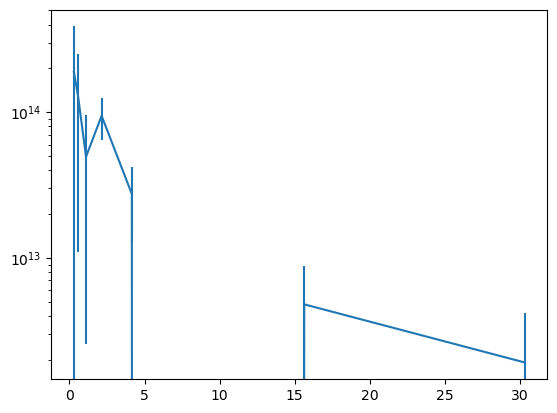

In [8]:
#sfu Data:
dir_loc_mcmc = "/global/cfs/cdirs/lsst/www/cluster_triaxiality/sfu/catalog/delta_sigma_all/"
f=dir_loc_mcmc + "MCMC"

from astropy.io import ascii

data=ascii.read(dir_loc_mcmc+'cluster_RM_DES_Y3_metacal_2_delta_sigma.csv')



for k in data.keys():
    print(k)

ds_mono = data['delta_sigma_t'].value*1E14 #In M_sun/Mpc^2
ds_mono_err = data['delta_sigma_t_err'].value*1E14 #In M_sun/Mpc^2
r_mono=data['r_Mpc'].value

plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err)
plt.yscale('log')

#MCMC parameters:
params_key=["M200c","c200c","e"]#,r"$\theta_{e}$ in radians"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 5000
nburns = 500
np.random.seed(0)

limits=[[1.0E13,5.0E16],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e
       #[-np.pi/2, 0]]    # theta_e #in degrees

#q_true=0.6 #default = 2/3 for the files in the same directory as this notebook
#ell_true= 1*(1-q_true**2)/(1+q_true**2)
#ell_true= 1*(1-q_true)/(1+q_true)
true_value=[None, None, None]#,None]
z_cl=0.35

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''


# PREP DATA:
#ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_binned_estimators_triaxiality(gamma1, gamma2, x_arcsec, 
#                                                                                                                      y_arcsec, z_cluster=0.47, z_source=0.8, cosmo=cosmo, r_min=0.3)

#If a physical cut is needed in monopole term:
#r_cut = 1.0
#ds_mono = ds_mono[r_mono > r_cut]
#ds_mono_err = ds_mono_err[r_mono > r_cut]
#r_mono = r_mono[r_mono > r_cut]

global run_estimator
global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad

### SFU's Mock clusters & shapes:

In [81]:
#Shenming's mock catalog:
q_true=0.7
dir_loc_mcmc = "Elliptical_lenses_data/catalog_horizontal_rescale_q"+str(q_true)+"/"
f=dir_loc_mcmc + "MCMC"

gamma1 = np.load(dir_loc_mcmc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc_mcmc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc_mcmc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc_mcmc+"y_arcsec.npy").flatten()

# Rotating the sample
#theta_e_true = np.pi/3
#gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec, theta_e_true)

#MCMC parameters:
params_key=["M200c","c200c","e"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 5000
nburns = 1000
np.random.seed(0)

limits=[[1.0E12,5.0E14],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e
       #[-np.pi/2, 0]]    # theta_e #in degrees
z_cl=0.47
z_gal=0.8
#q_true=0.6 #default = 2/3 for the files in the same directory as this notebook
#ell_true= 1*(1-q_true**2)/(1+q_true**2)
ell_true= 1*(1-q_true)/(1+q_true)
true_value=[2.0E14, 3.89055, ell_true]

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''
# PREP DATA:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_binned_estimators_triaxiality(gamma1, gamma2, x_arcsec, 
                                                                                                                      y_arcsec, z_cluster=0.47, z_source=0.8, cosmo=cosmo, r_min=0.3)

#If a physical cut is needed in monopole term:
#r_cut = 1.0
#ds_mono = ds_mono[r_mono > r_cut]
#ds_mono_err = ds_mono_err[r_mono > r_cut]
#r_mono = r_mono[r_mono > r_cut]

global run_estimator
global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad


### SkySim5000 Clusters and shapes:

top_4th
top_con
bottom
DS_mon
DS_4th
DS_con
cov_mon
cov_4th
cov_con
arr_0
[ 0.18778632  0.29762126  0.47169791  0.74759081  1.18485159  1.87786321
  2.97621262  4.71697912  7.4759081  11.84851585]
[1.12896597e+14 1.43899255e+14 1.51333515e+14 1.28066205e+14
 9.70415369e+13 6.42407382e+13 3.78975946e+13 2.05970139e+13
 9.46259199e+12 5.33329040e+12]


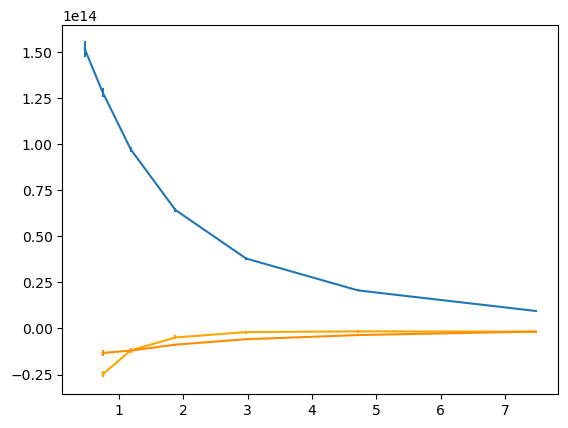

In [44]:
dir_loc_mcmc = "Elliptical_lenses_data/SKYSIM5000/"
f=dir_loc_mcmc+'Stacked_DSquad_SKYSIM5000_R10_0.1-10.0.npz'

data=np.load(dir_loc_mcmc+'Stacked_DSquad_SKYSIM5000_R10_0.1-10.0.npz')
for k in data.keys():
    print(k)
ds_mono = data['DS_mon']*1E12#*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_mono_err = np.sqrt(np.diag(data['cov_mon']))*1E12#*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2

ds_quad_4theta = data['DS_4th']*1E12#*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_4theta_err = np.sqrt(np.diag(data['cov_4th']))*1E12#*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_const = data['DS_con']*1E12#*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
ds_quad_const_err = np.sqrt(np.diag(data['cov_con']))*1E12#*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
Stacked_DSquad_SKYSIM5000_R10_0.1-10.0.npz

#r=np.logspace(np.log10(0.1), np.log10(10.0), 11)
#r = (np.sqrt(r[:-1]*r[1:])) #data is in Mpc/h units
#r=r/(cosmo.be_cosmo["h"]) # In Mpc
#print(r)
Rbins=10
R = np.logspace(np.log10(0.1),np.log10(10.),Rbins+1) #[Mpc/h]
R_mid = (2./3.)*(R[1:]**3 - R[:-1]**3)/(R[1:]**2 - R[:-1]**2)
r=R_mid/(cosmo.be_cosmo["h"]) # In Mpc
r_mono = r
r_quad = r
print(r)

'''
r_quad_cut = 0.2
ds_quad_4theta = ds_quad_4theta[r > r_quad_cut]
ds_quad_4theta_err = ds_quad_4theta_err[r > r_quad_cut]
ds_quad_const = ds_quad_const[r > r_quad_cut]
ds_quad_const_err = ds_quad_const_err[r > r_quad_cut]
r_quad = r[r > r_quad_cut]
'''

print(ds_mono)
#plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err)
#plt.xscale('log')
#plt.yscale('log')

#MCMC parameters:
params_key=["M200c","c200c","e"]#,r"$\theta_{e}$ in radians"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 5000
nburns = 500
np.random.seed(0)

limits=[[1.0E13,1.0E16],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e
       #[-np.pi/2, 0]]    # theta_e #in degrees

#q_true=0.6 #default = 2/3 for the files in the same directory as this notebook
#ell_true= 1*(1-q_true**2)/(1+q_true**2)
#ell_true= 1*(1-q_true)/(1+q_true)
true_value=[None, None, None]#,None]
z_cl=0.35

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''


# PREP DATA:
#ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_binned_estimators_triaxiality(gamma1, gamma2, x_arcsec, 
#                                                                                                                      y_arcsec, z_cluster=0.47, z_source=0.8, cosmo=cosmo, r_min=0.3)

#If a physical cut is needed in monopole term:

r_cut = 0.4
r_cut_outer = 8.0
ds_mono = ds_mono[(r_mono > r_cut) & (r_mono < r_cut_outer)]
ds_mono_err = ds_mono_err[(r_mono > r_cut) & (r_mono < r_cut_outer)]
r_mono = r_mono[(r_mono > r_cut) & (r_mono < r_cut_outer)]

r_quad_cut = 0.5
r_quad_cut_upper = 8.0 
ds_quad_const = ds_quad_const[(r_quad > r_quad_cut) & (r_quad < r_quad_cut_upper)]
ds_quad_const_err = ds_quad_const_err[(r_quad > r_quad_cut) & (r_quad < r_quad_cut_upper)]
ds_quad_4theta = ds_quad_4theta[(r_quad > r_quad_cut) & (r_quad < r_quad_cut_upper)]
ds_quad_4theta_err = ds_quad_4theta_err[(r_quad > r_quad_cut) & (r_quad < r_quad_cut_upper)]
r_quad = r_quad[(r_quad > r_quad_cut) & (r_quad < r_quad_cut_upper)]

plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err)
plt.errorbar(r_quad, ds_quad_const,  yerr=ds_quad_const_err, label='data', color='orange')
plt.errorbar(r_quad, ds_quad_4theta,  yerr=ds_quad_4theta_err, label='data', color='darkorange')

global run_estimator
global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad

### McClintock's Original WL Dataset: 
From the paper (https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1352M/abstract)

        R         
------------------
0.2613135296321218
0.4118700609458054
0.6508142140568394
1.0264934388927616
1.6185738283652658
2.5526326909842028        DS_t       
------------------
107730584056198.17
 82375871220213.58
 58638789584314.48
 45621610862614.77
 35857254008637.81
17473050588116.963      DS_t_err     
------------------
10482316554692.164
  5730258535869.95
 3982167258669.353
 2605196399259.124
1815097474071.8335
1132748642295.7122
Percent bias in log10 Mass =  0.176 %
Percent bias =  5.687 %


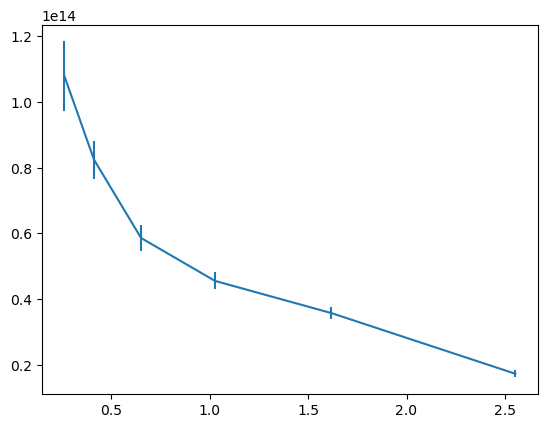

In [113]:
'''
richness bins are ['20.0 - 30.0', '30.0 - 45.0', '45.0 - 60.0', '60.0 - 500.0']
z bins are ['0.2 - 0.35', '0.35 - 0.5', '0.5 - 0.65']
'''
z_bin_means = [(0.2+0.35)/2, (0.35+0.5)/2, (0.5+0.65)/2]
l_bin = 4 # Bins from 3 to 6
z_bin = 0 # Bins from 0 to 2

dir_loc_mcmc = "Elliptical_lenses_data/McClintock_WL_data/"
f=dir_loc_mcmc+f'full-unblind-v2-mcal-zmix_y1subtr_l{l_bin}_z{z_bin}_profile.dat'
    
#df = pd.read_csv(f)
#print(df.columns)

from astropy.io import ascii
data = ascii.read(f)
data['R'] = data['col1']
data['DS_t'] = data['col2']
data['DS_t_err'] = data['col3']
data['DS_x'] = data['col1']
data['DS_x_err'] = data['col1']



ds_mono = data['DS_t']*1E12 #In M_sun/Mpc^2
ds_mono_err = data['DS_t_err']*1E12*(cosmo.be_cosmo["h"]) #In M_sun/Mpc^2
r_mono = data['R']



r_mono_cut = 0.2
r_mono_cut_l = 3.0
ds_mono = ds_mono[(r_mono > r_mono_cut) & (r_mono < r_mono_cut_l)]
ds_mono_err = ds_mono_err[(r_mono > r_mono_cut) & (r_mono < r_mono_cut_l)]
r_mono = r_mono[(r_mono > r_mono_cut) & (r_mono < r_mono_cut_l)]

print(r_mono,ds_mono,ds_mono_err)

plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err)
#plt.xscale('log')
#plt.yscale('log')

#MCMC parameters:
params_key=["M200c","c200c","e"]#,r"$\theta_{e}$ in radians"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 2000
nburns = 500
np.random.seed(0)

limits=[[1.0E13,5.0E16],  # mdelta
       [0.0,20.0],     # cdelta
       [0.000000001,0.0001]]   # e

true_value=[None, None, None]
z_cl=z_bin_means[z_bin]

global run_estimator
global ds_mono,ds_mono_err,r_mono#,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad

# RESULTS:
# l z True_Mass(M200m) Fit_Mass(M200m) Bias(%)
# 3 0  14.191 1.61E14 3.578
# 3 1  14.162 1.39E14 -4.468
# 3 2  14.083 1.26E14 3.921
# 4 0  14.477 3E14 -0.982
# 4 1  14.446 2.95E14 5.337
# 4 2  14.456 2.84E14 -0.619
# 5 0  14.608 4.04E14 -0.373
# 5 1  14.643 4.52E14 2.756
# 5 2  14.648 4.58E14 2.919
# 6 0  14.913 8.38E14 2.3
# 6 1  14.899 8.11E14 2.281
# 6 2  14.879 7.53E14 -0.509

M_true_200m = 14.477
fit_mass = 3.18E14
print('Percent bias in log10 Mass = ',np.round((np.log10(fit_mass) - M_true_200m)/M_true_200m*100,3),'%')
print('Percent bias = ',np.round((fit_mass - 10**M_true_200m)/fit_mass*100,3),'%')

Starting guesses for  10  chains:
[[1.32351350e+16 7.19015801e+00 5.64537783e-01]
 [3.87139421e+16 8.74063908e+00 4.34271638e-01]
 [2.28129551e+16 1.39526239e+01 9.78491262e-01]
 [2.84260131e+16 1.20450943e+00 1.01114158e-01]
 [9.49302124e+14 1.33353343e+01 2.06867101e-01]
 [3.08855985e+16 1.34127574e+01 1.59780292e-01]
 [3.06086652e+16 4.20765122e+00 6.46611931e-01]
 [3.08505305e+16 2.57852595e+00 2.50833357e-01]
 [4.71879664e+16 6.30856702e+00 4.61701034e-01]
 [3.40941968e+16 7.27421542e+00 2.42056894e-01]]


100%|██████████| 5000/5000 [07:24<00:00, 11.26it/s]


Time taken:445.0 seconds


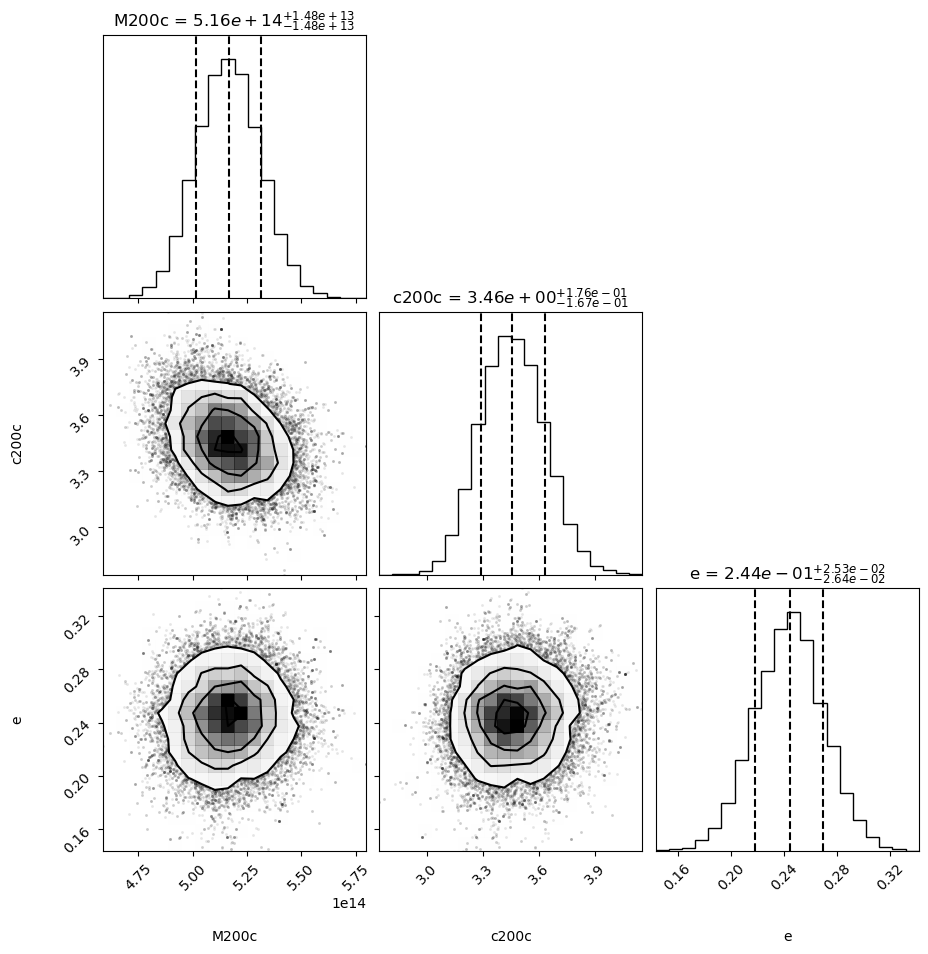

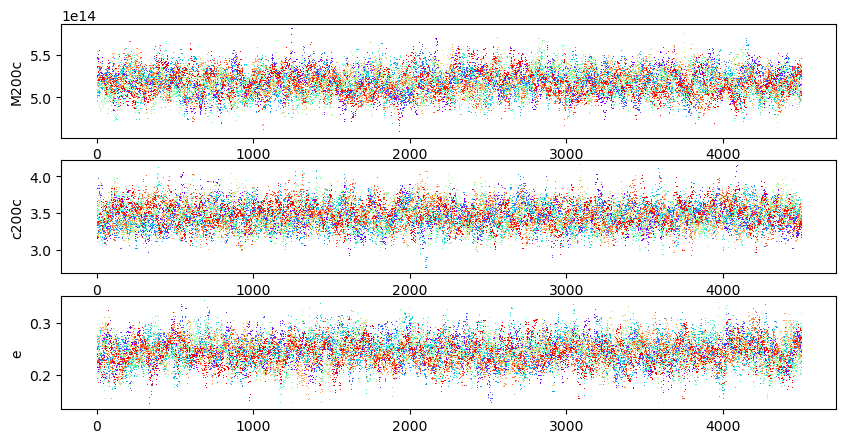

In [11]:
# CALL EMCEE
post, mean, err_plus, err_minus = emcee_wrapper(params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,
                                                nsteps=nsteps, nburn=nburns, filename=f)


In [51]:
# Lambda   Z     Tae's Fit_M  True_M  Bias(%)
# 20-30 0.2-0.35 -- 14.191 39.596
# 30-45 0.2-0.35 4.8E14 14.477 37.517
# 45-60 0.2-0.35 6.3E14 14.608 35.634
# 60-500 0.2-0.35 1.37E15 14.913 40.258

# 20-30 0.35-0.5  14.162 55.182
# 30-45 0.35-0.5  14.446 54.37
# 45-60 0.35-0.5 9.11E14 14.643 51.752
# 60-500 0.35-0.5 1.52E15 14.899 47.862

# 20-30 0.5-0.65  14.083 73.568
# 30-45 0.5-0.65  14.456 64.414
# 45-60 0.5-0.65 1.15E15 14.648 61.336
# 60-500 0.5-0.65 2.06E15 14.879 63.261

M_true_200m = 14.191
fit_mass = 7.53E14
print('Percent bias in log10 Mass = ',np.round((np.log10(fit_mass) - M_true_200m)/M_true_200m*100,3),'%')
print('Percent bias = ',np.round((fit_mass - 10**M_true_200m)/fit_mass*100,3),'%')

Percent bias in log10 Mass =  0.112 %
Percent bias =  3.578 %


In [48]:
(np.log10(4.51E14) - 14.477)/14.477*100

1.2238484622363786

## Plotting from the stored HDF5 File:

In [43]:
dir_loc_mcmc = "Elliptical_lenses_data/SKYSIM5000/"
f=dir_loc_mcmc + "MCMC"

reader = emcee.backends.HDFBackend(f)
nburns=500
post = reader.get_chain(discard=nburns, flat=True)
print(len(post))

5000


mdelta_fit= 516465313913300.56 cdelta_fit= 3.4565016178501664 ell_fit =  0.24432523095099562
Computed and Plotted 1-sigma intervals for Mono...
Computed and Plotted 1-sigma intervals for Const...
Computed and Plotted 1-sigma intervals for 4theta...


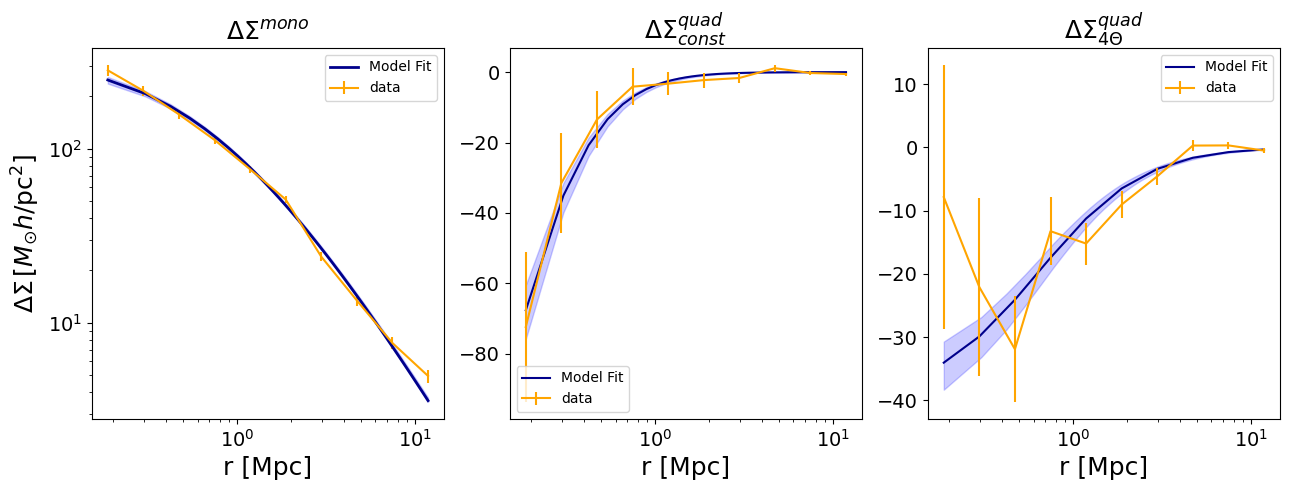

In [15]:
import matplotlib
dir_loc_mcmc = "Elliptical_lenses_data/DESY1RM-Y3shape/"
f=dir_loc_mcmc+'DSquad_DESY1RM-Y1shape_R10_0.1-10.0_new.h5'
#dir_loc_mcmc = "Elliptical_lenses_data/SKYSIM5000/"
#f=dir_loc_mcmc+'Stacked_DSquad_SKYSIM5000_R10_0.1-10.0.h5'
#dir_loc_mcmc = "Elliptical_lenses_data/McClintock_WL_data/"
#f=dir_loc_mcmc+f'full-unblind-v2-mcal-zmix_y1subtr_l{l_bin}_z{z_bin}_profile.h5'

#q_true=0.7
#dir_loc_mcmc = "Elliptical_lenses_data/catalog_horizontal_rescale_q"+str(q_true)+"/"
#f=dir_loc_mcmc + "MCMC"
#reader = emcee.backends.HDFBackend(f)
#nburns=500
#post = reader.get_chain(discard=nburns, flat=True)

mean=[]
err_minus=[]
err_plus=[]
for i in range(len(params_key)):
    mean.append(np.quantile((post[:,i].flatten()), 0.5))
    err_minus.append(np.quantile((post[:,i].flatten()), 0.16))
    err_plus.append(np.quantile((post[:,i].flatten()), 0.84))
mean = np.array(mean)
err_plus = np.array(err_plus) - mean
err_minus = mean - np.array(err_minus)

mdelta_fit = mean[0]#1E15#mean[0]#1.5E15#mean[0]
cdelta_fit = mean[1]#3.7#mean[1]
ell_fit = mean[2]
print("mdelta_fit=",mdelta_fit,"cdelta_fit=",cdelta_fit, "ell_fit = ",ell_fit)
#theta_e_fit = mean[3] #in degrees
cosmo = Cosmology(H0=70.0, Omega_dm0=0.2248, Omega_b0=0.3 - 0.2248, Omega_k0=0.0)

fig,ax = plt.subplots(1,3, figsize=[13,5])
ax[0].errorbar(r_mono, ds_mono/1E12, yerr=np.abs(ds_mono_err)/1E12, label='data', color='orange')
r=np.linspace(np.min(r_mono), np.max(r_mono), 100)
ds_model = clmm.compute_excess_surface_density_triaxial(ell=ell_fit, r_proj=r, mdelta=mdelta_fit, cdelta=cdelta_fit, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             n_grid=10000, delta_mdef=200, massdef='critical', term='mono')

ax[0].plot(r, ds_model/1E12, label='Model Fit', color='darkblue', lw=2)
#plt.plot(r_mono, ds_model, label='model[TRUTH]', color='gray', lw=2)
#plt.plot(r_mono, (ds_mono-ds_model)/ds_model, label='(data - model) / model', color='darkblue', ls='dashed')
#plt.yscale('log')
ax[0].set_xlabel('r [Mpc]', fontsize=18)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_title(r'$\Delta\Sigma^{mono}$', fontsize=18)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[0].set_ylabel(r'$\Delta\Sigma \,[M_{\odot} h/\rm{pc}^{2}]$', fontsize=18)
ax[0].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[0].legend()
#plt.xlim([1.75,2.25])


r=np.linspace(np.min(r_quad), np.max(r_quad), 100)
ds_model = clmm.compute_excess_surface_density_triaxial(ell=ell_fit, r_proj=r, mdelta=mdelta_fit, cdelta=cdelta_fit, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             n_grid=10000, delta_mdef=200, massdef='critical', term='quad_const')
ax[1].plot(r, ds_model/1E12, label='Model Fit', color='darkblue')
ax[1].errorbar(r_quad, ds_quad_const/1E12,  yerr=ds_quad_const_err/1E12, label='data', color='orange')
ax[1].set_yscale('linear')
ax[1].set_xscale('log')
ax[1].set_title(r'$\Delta\Sigma^{quad}_{const}$', fontsize=18)
ax[1].set_xlabel('r [Mpc]', fontsize=18)
ax[1].tick_params(axis='both', which='both', labelsize=14)
ax[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[1].legend()


ds_model = clmm.compute_excess_surface_density_triaxial(ell=ell_fit, r_proj=r_quad, mdelta=mdelta_fit, cdelta=cdelta_fit, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             n_grid=10000, delta_mdef=200, massdef='critical', term='quad_4theta')
sns.lineplot(x=r_quad, y=ds_model/1E12, ax=ax[2], label='Model Fit', color='darkblue')

ax[2].errorbar(r_quad, ds_quad_4theta/1E12,  yerr=ds_quad_4theta_err/1E12, label='data', color='orange')
ax[2].set_yscale('linear')
ax[2].set_xscale('log')
ax[2].set_title(r'$\Delta\Sigma^{quad}_{4\Theta}$', fontsize=18)
ax[2].set_xlabel('r [Mpc]', fontsize=18)
ax[2].tick_params(axis='both', which='both', labelsize=14)
ax[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[2].legend()
plt.tight_layout()



plot_confidence_bands = True
if plot_confidence_bands == True:
    post_s=post[0:500]
    ds_model = np.zeros([len(post_s),len(r)])
    for i,p in enumerate(post_s):
        ds_model[i,:] = clmm.compute_excess_surface_density_triaxial(ell=p[2], r_proj=r, mdelta=p[0], cdelta=p[1], z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                                 n_grid=10000, delta_mdef=200, massdef='critical', term='mono')
    model_minus = np.zeros(len(r))
    model_plus = np.zeros(len(r))
    for i,r_i in enumerate(r):
        model_minus[i] = np.quantile(ds_model[:,i],0.16)
        model_plus[i] = np.quantile(ds_model[:,i],0.84)
    ax[0].fill_between(r, model_minus/1E12, model_plus/1E12, color='blue', alpha=0.2)
    print('Computed and Plotted 1-sigma intervals for Mono...')
    

    ds_model = np.zeros([len(post_s),len(r)])
    for i,p in enumerate(post_s):
        ds_model[i,:] = clmm.compute_excess_surface_density_triaxial(ell=p[2], r_proj=r, mdelta=p[0], cdelta=p[1], z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                                 n_grid=10000, delta_mdef=200, massdef='critical', term='quad_const')
    model_minus = np.zeros(len(r))
    model_plus = np.zeros(len(r))
    for i,r_i in enumerate(r):
        model_minus[i] = np.quantile(ds_model[:,i],0.16)
        model_plus[i] = np.quantile(ds_model[:,i],0.84)
    ax[1].fill_between(r, model_minus/1E12, model_plus/1E12, color='blue', alpha=0.2)
    print('Computed and Plotted 1-sigma intervals for Const...')
    

    ds_model = np.zeros([len(post_s),len(r)])
    for i,p in enumerate(post_s):
        ds_model[i,:] = clmm.compute_excess_surface_density_triaxial(ell=p[2], r_proj=r, mdelta=p[0], cdelta=p[1], z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                                 n_grid=10000, delta_mdef=200, massdef='critical', term='quad_4theta')
    model_minus = np.zeros(len(r))
    model_plus = np.zeros(len(r))
    for i,r_i in enumerate(r):
        model_minus[i] = np.quantile(ds_model[:,i],0.16)
        model_plus[i] = np.quantile(ds_model[:,i],0.84)
    ax[2].fill_between(r, model_minus/1E12, model_plus/1E12, color='blue', alpha=0.2)
    print('Computed and Plotted 1-sigma intervals for 4theta...')

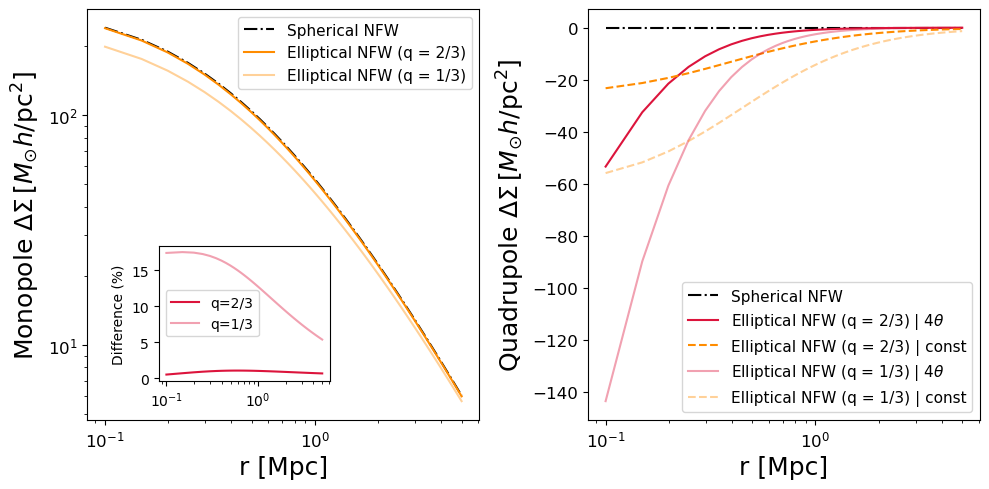

In [77]:
r=np.linspace(0.1, 5, 100)
mdelta_fit = 2.0E14 # q = 0.7
cdelta_fit = 3.89055 # q = 0.7
ell_fit = 0.176 # q = 0.7
mdelta_fit_0_3 = 1.9E14 # q = 0.3
cdelta_fit_0_3 = 3.39 # q = 0.3
ell_fit_0_3 =  0.497 # q = 0.3

z_cl = 0.47

# q = 0
ds_model_e_0 = clmm.compute_delta_sigma_excess_triaxiality(0.0, r, mdelta_fit, cdelta_fit, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')
ds_const_model_e_0 = clmm.compute_delta_sigma_const_triaxiality(0.0, r, mdelta_fit, cdelta_fit, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')
ds_4theta_model_e_0 = clmm.compute_delta_sigma_4theta_triaxiality(0.0, r, mdelta_fit, cdelta_fit, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')

# q = 0.7
ds_model = clmm.compute_delta_sigma_excess_triaxiality(ell_fit, r, mdelta_fit, cdelta_fit, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')
ds_const_model = clmm.compute_delta_sigma_const_triaxiality(ell_fit, r, mdelta_fit, cdelta_fit, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')
ds_4theta_model = clmm.compute_delta_sigma_4theta_triaxiality(ell_fit, r, mdelta_fit, cdelta_fit, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')

# q = 0.3
ds_model_0_3 = clmm.compute_delta_sigma_excess_triaxiality(ell_fit_0_3, r, mdelta_fit_0_3, cdelta_fit_0_3, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')
ds_const_model_0_3 = clmm.compute_delta_sigma_const_triaxiality(ell_fit_0_3, r, mdelta_fit_0_3, cdelta_fit_0_3, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')
ds_4theta_model_0_3 = clmm.compute_delta_sigma_4theta_triaxiality(ell_fit_0_3, r, mdelta_fit_0_3, cdelta_fit_0_3, z_cluster=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             sample_N=10000, delta_mdef=200, massdef='critical')
fig,ax = plt.subplots(1,2, figsize=[10,5])

sns.lineplot(x=r, y=ds_model_e_0/1E12, ax=ax[0], markers = True, ms=20.0, color='black', ls='dashdot', label='Spherical NFW')
sns.lineplot(x=r, y=ds_model/1E12, ax=ax[0], color='darkorange', label='Elliptical NFW (q = 2/3)', ls='solid')
sns.lineplot(x=r, y=ds_model_0_3/1E12, ax=ax[0], color='darkorange', label='Elliptical NFW (q = 1/3)', ls='solid', alpha=0.4)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('r [Mpc]', fontsize=18)
ax[0].set_ylabel(r'Monopole $\Delta\Sigma \,[M_{\odot} h/\rm{pc}^{2}]$', fontsize=18)
ax[0].tick_params(axis='both', which='both', labelsize=12)
ax[0].legend(fontsize=11)
plt.tight_layout()
axin1 = ax[0].inset_axes(
        [0.18, 7, 1, 20], transform=ax[0].transData)

sns.lineplot(x=r,y=(1-ds_model/ds_model_e_0)*100, ax=axin1, color='crimson', label='q=2/3')
sns.lineplot(x=r,y=(1-ds_model_0_3/ds_model_e_0)*100, ax=axin1, color='crimson', alpha=0.4, label='q=1/3')
axin1.set_xscale('log')
axin1.set_ylabel('Difference (%)', fontsize=10)
axin1.legend()
#axin1.set_xlabel('r', fontsize=15)

sns.lineplot(x=r, y=ds_const_model_e_0/1E12, ax=ax[1], color='black', ls='dashdot', label='Spherical NFW')
sns.lineplot(x=r, y=ds_const_model/1E12, ax=ax[1], color='crimson', label=r'Elliptical NFW (q = 2/3) | $4\theta$')
sns.lineplot(x=r, y=ds_4theta_model/1E12, ax=ax[1], color='darkorange', label='Elliptical NFW (q = 2/3) | const', ls='dashed')

sns.lineplot(x=r, y=ds_const_model_0_3/1E12, ax=ax[1], color='crimson', label=r'Elliptical NFW (q = 1/3) | $4\theta$', alpha=0.4)
sns.lineplot(x=r, y=ds_4theta_model_0_3/1E12, ax=ax[1], color='darkorange', label='Elliptical NFW (q = 1/3) | const', ls='dashed', alpha=0.4)
#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('r [Mpc]', fontsize=18)
ax[1].set_ylabel(r'Quadrupole $\Delta\Sigma \,[M_{\odot} h/\rm{pc}^{2}]$', fontsize=18)
ax[1].tick_params(axis='both', which='both', labelsize=12)
ax[1].legend(fontsize=11)
plt.tight_layout()

(45000, 3)


'\nfor yi in range(ndim):\n    for xi in range(yi):\n        ax = axes[yi, xi]\n        ax.axvline(true_value[xi], color="r")\n        ax.axhline(true_value[yi], color="r")\n        ax.plot(true_value[xi], true_value[yi], "sr")\n        #if yi == 1:\n        #    ax.set_xlim([2000,2200])\n'

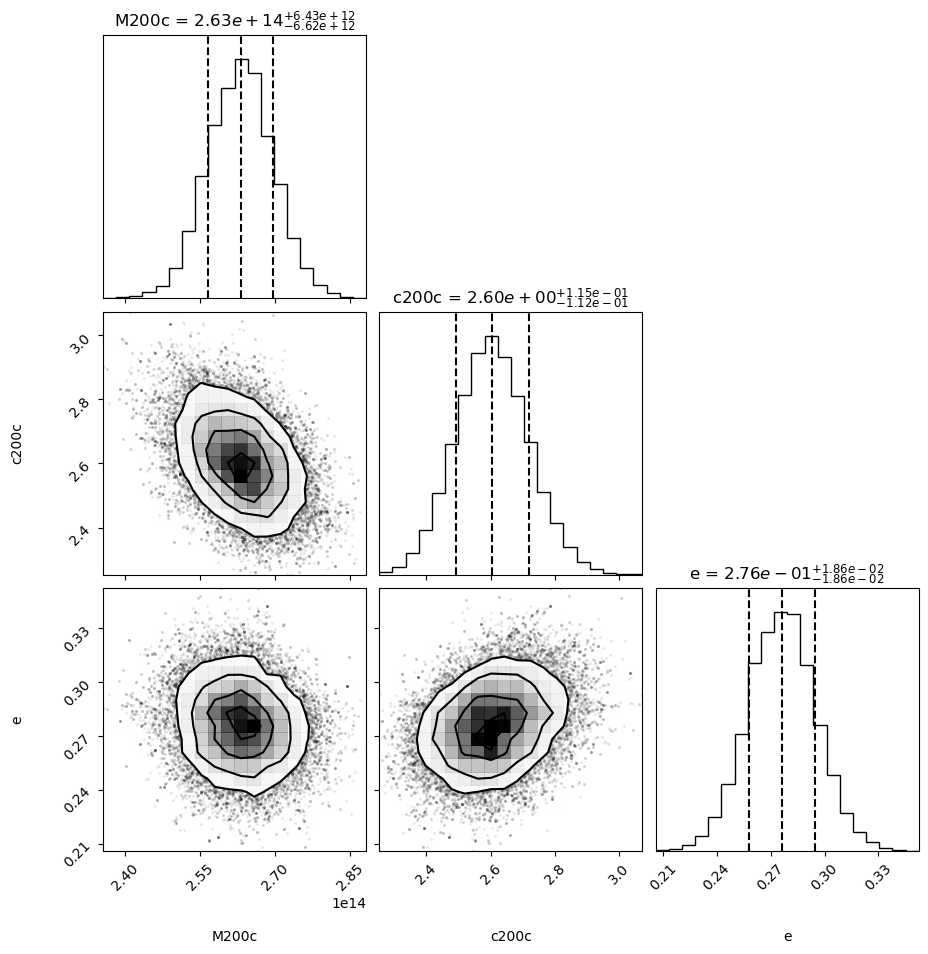

In [41]:
reader = emcee.backends.HDFBackend(f)
post = np.concatenate(reader.get_chain(discard=nburns))
print(np.shape(post))
fig = plt.figure(figsize=[10,10])
figure = corner.corner(post,labels=params_key, quantiles=[0.16, 0.5, 0.84], 
                       show_titles=True, title_fmt='.2e', fig=fig)
figure.patch.set_facecolor('white')
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the histograms
'''
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true_value[xi], color="r")
        ax.axhline(true_value[yi], color="r")
        ax.plot(true_value[xi], true_value[yi], "sr")
        #if yi == 1:
        #    ax.set_xlim([2000,2200])
'''

['M200c', 'c200c', 'e']


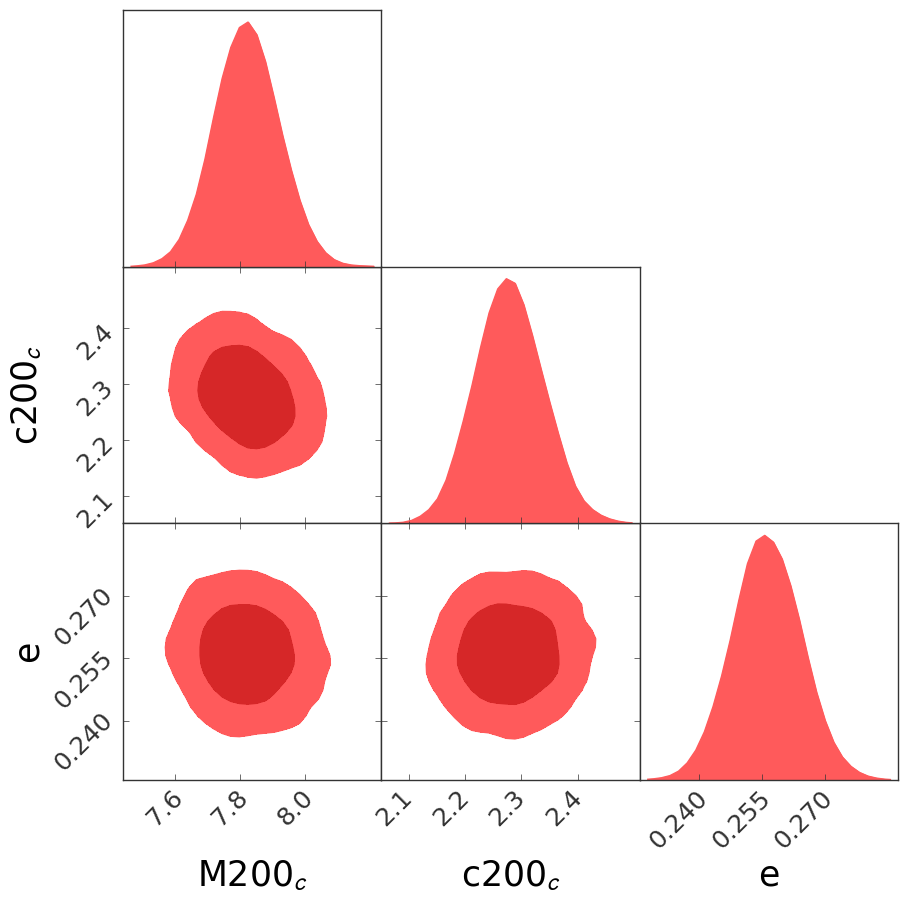

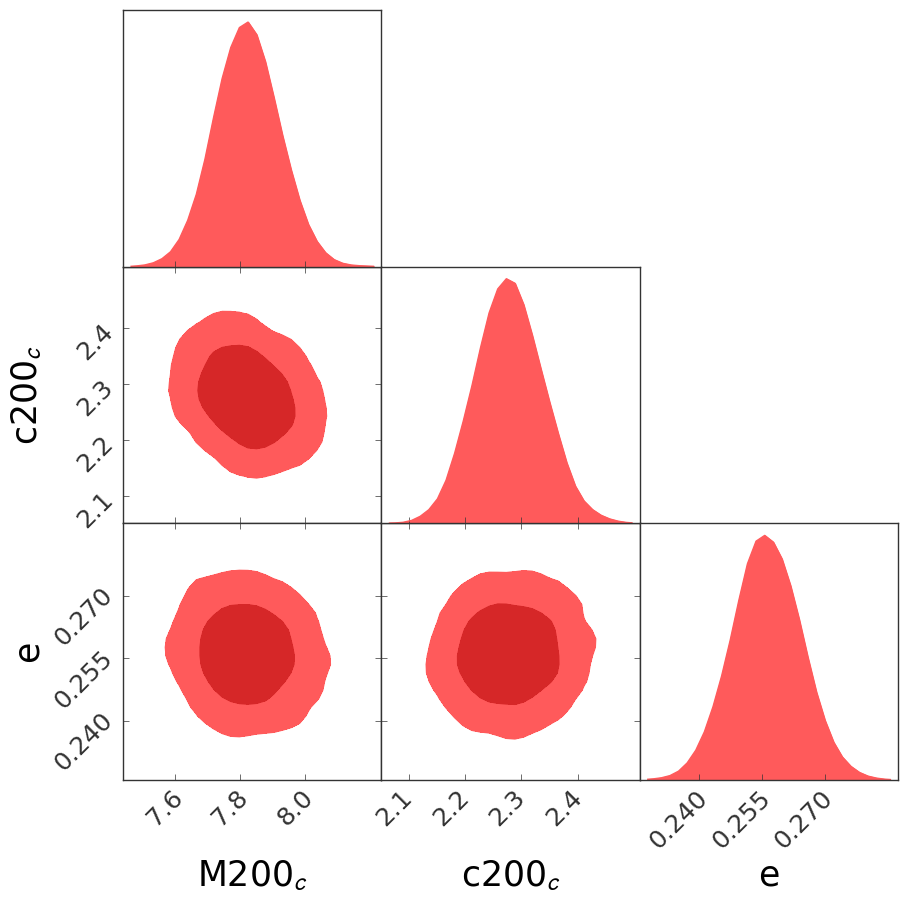

In [8]:
#dir_loc_mcmc = "Elliptical_lenses_data/DESY1RM-Y3shape/"
#f=dir_loc_mcmc + "MCMC"
dir_loc_mcmc = "Elliptical_lenses_data/SKYSIM5000/"
f=dir_loc_mcmc+'Stacked_DSquad_SKYSIM5000_R10_0.1-10.0.h5'

nburns = 500
reader = emcee.backends.HDFBackend(f)
post = np.concatenate(reader.get_chain(discard=nburns))
params_key=["M200c","c200c","e"]#,r"$\theta_{e}$ in radians"]
ndim = len(params_key)

import pygtc
print(params_key)
names=['M200$_{c}$','c200$_{c}$','e']
font = {'family': 'DejaVu Sans',
        'weight': 'normal',
        'size': 18,
        }
font_label = {'family': 'DejaVu Sans',
        'weight': 'normal',
        'size': 25,
        }
font_ticks = {'family': 'DejaVu Sans',
        'weight': 'normal',
        'size': 18,
        }
#'MNRAS_page'
post[:,0] = post[:,0]/1E14
pygtc.plotGTC(chains=[post],
              paramNames=names,
              colorsOrder=["reds"],
              figureSize=30/3,
             customLabelFont=font_label,
             customTickFont=font_ticks)

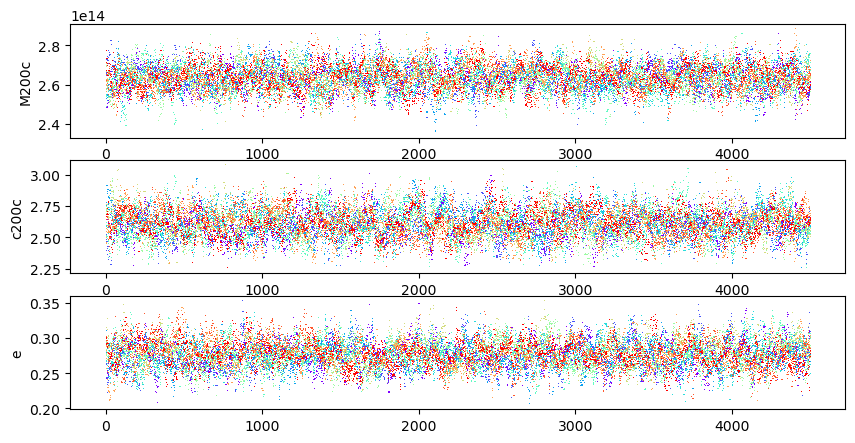

In [42]:
#Chain plot:
color=iter(cm.rainbow(np.linspace(0,1,nwalkers)))
# set up a plot with two windows, one for each parameter:
plt.figure(figsize=(10,5))
#plt.patch.set_facecolor('white')
for i in range(len(params_key)):
    plt.subplot(100*len(params_key)+10+i+1)
    plt.ylabel(params_key[i], fontsize=10)
for j in range(nwalkers):
    c=next(color)
    for i in range(len(params_key)):
        plt.subplot(100*len(params_key)+10+i+1)
        plt.plot(reader.get_chain(discard=nburns)[:,j,i], ',', color=c)